# Introduction

In this session, we'll take a look at traditional forecasting using RNNs in TensorFlow.

## RNN Background

RNNs use a `for` loop to iterate over the timesteps of a sequence, while maintaining internal state that encodes information about the timesteps it has seen so far. 

Note that this leads to the **exploding gradient** problem, where the gradients grow bigger and bigger until the optimization routine diverges. This happens because in an RNN, you're hitting the same RNN cell with a vector for each time step of your sequence. So RNNs are even more susceptible to weight update difficulties during training.

We can understand this as, when we want to train our RNN (update the weights), we first "unroll" the recurrent unit, and we update the same set of weights using the backpropagation from each time step for a given sample.

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

There are three built-in RNN layers provided by Keras:

* `keras.layers.SimpleRNN` - a fully-connected RNN where the output from the previous timestep is fed into the next timestep
* `keras.layers.GRU`
* `keras.layers.LSTM`


Here is the simplest "hello-world" RNN model you can think of creating:

In [26]:
model = keras.Sequential()

# we expect an input vocab size of 1,000
model.add(layers.Embedding(input_dim=1_000, output_dim=64))

# a LSTM layer with 128 internal units
model.add(layers.LSTM(128))

# add a final Dense layer with 10 units
model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 164106 (641.04 KB)
Trainable params: 164106 (641.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The built-in RNNs have the following features:

* `dropout` and `recurrent_dropout`
* `go_backwards` - process an input sequence in reverse
* `unroll` - unroll the time step loop, which can lead to a speedup when processing short sequences on CPU

By default, the output of an RNN layer contains a single vector per sample. 
This vector is always the cell output corresponding to the last timestep of your input sequences. This vector contains information about the entire input sequence, and its shape is `(batch_size, units)`, where `units` is the number of internal units we defined before. 

You can force Keras RNN layers to return the entire sequence of outputs for each sample (so one vector per timestep per sample), by passing `return_sequences=True`. The shape of this output would be `(batch_size, timesteps, units)`.

# Forecasting a Time Series

Now we're going to go through an example of a mainstream time series forecasting task you might have attempted using a traditional ARIMA model.

In [27]:
path_to_chicago_ride_data = pathlib.Path('../data/CTA_-_Ridership_-_Daily_Boarding_Totals.csv')
path_to_chicago_ride_data.exists()

True

In [28]:
chicago_ride_data = pd.read_csv(path_to_chicago_ride_data, parse_dates=['service_date'])
chicago_ride_data.columns = ["date", "day_type", "bus", "rail", "total"]
chicago_ride_data = (
    chicago_ride_data
    .sort_values("date")
    .set_index("date")
    .drop("total", axis=1)
    .drop_duplicates()
).copy()
chicago_ride_data.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


So, for example, on January 1st, 2001, we had 297,192 people that boarded a bus inChiago, and 126,455 that boarded a train.

`day_type` contains `W` for weekdays, `A` for Saturdays and `U` for Sundays and holidays.

We can plot this data like this:

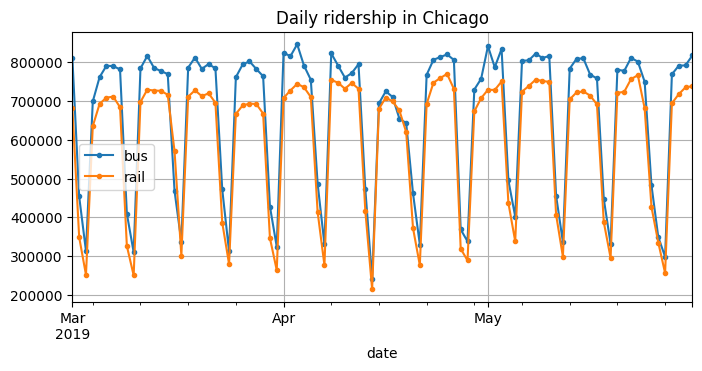

In [8]:
chicago_ride_data["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.title("Daily ridership in Chicago")
plt.show()

We have strong weekly seasonality here. A good baseline model is to predict the same value we had 7 days ago. 

In [9]:
diff_7 = chicago_ride_data[["bus", "rail"]].diff(7)["2019-03":"2019-05"].copy()
diff_7.head()

,bus,rail
date,,
2019-03-01,13927.0,-20019.0
2019-03-02,47280.0,21213.0
2019-03-03,25171.0,11672.0
2019-03-04,-63771.0,-45491.0
2019-03-05,-11268.0,-6517.0


The top plot is the original series, with the lagged value from 7 days ago, and the bottom plot is the time series where we've diffed each value with its value from 7 days ago.

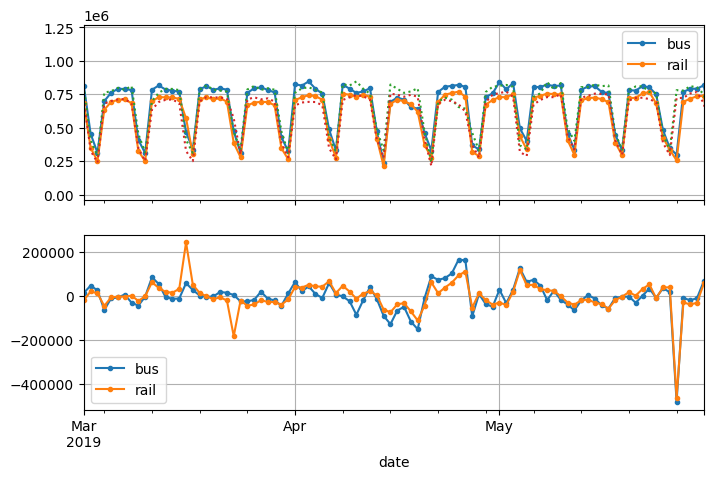

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
chicago_ride_data.plot(ax=axs[0], marker=".") # original time series
chicago_ride_data.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":") # original time series 7 days ago
diff_7.plot(ax=axs[1], grid=True, marker=".") # original time series, MINUS that of 7 days ago
plt.show()

If you look at the top plot, you can see that the value of the series on a given day is highly autocorrelated with that of itself from 7 days ago.

We can compute our mean absolute error on this naive prediction like this:

In [11]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

So our bus prediction is off on average by about 43,915 riders, and our rail prediction is off on average by about 42,143 riders.

Now, we'll try using a SARIMA model (an ARIMA model with a seasonal component). We have 7 parameters:

* p - use p auto-regressive terms
* d - use d rounds of differencing
* q - use the previous q forecast errors 
* P - the same as above, but for modeling the time series at t-s, t-2s, etc.
* D
* Q - 
* s - the period of the seasonal pattern (7 for every 7 days)

In [14]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = chicago_ride_data.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(
    rail_series,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 7),
)
model = model.fit()
predictions = model.forecast()

Our prediction for June 1st, 2019 is quite off:

In [23]:
predicted_forecast = predictions.values[0]
actual_ridership = chicago_ride_data.loc['2019-06-01']['rail']
print(f"Predicted forecast: {predictions.index[0].strftime('%Y-%m-%d')}: {predicted_forecast:,.0f}")
print(f"Actual ridership: {actual_ridership:,.0f}")
print(f"Absolute Difference: {abs(actual_ridership - predicted_forecast):,.0f}")
print(f"Percent absolute difference: {abs(actual_ridership - predicted_forecast) / actual_ridership:.2%}")

Predicted forecast: 2019-06-01: 427,759
Actual ridership: 379,044
Absolute Difference: 48,715
Percent absolute difference: 12.85%


So our MAE is 48,714 here. This isn't very good. It's about 12.9% percent off.

Let's average the absolute error over a few days to get a more representative sample of performance for our RNN:

In [24]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = chicago_ride_data.loc[origin:end_date]["rail"].asfreq("D")
predictions = []
for today in tqdm(time_period.shift(-1)):
    model = ARIMA(
        rail_series.loc[origin:today],
        order=(1, 0, 0),
        seasonal_order=(0, 1, 1, 7),
    )
    model = model.fit()
    prediction = model.forecast()[0]
    predictions.append(prediction)

predictions = pd.Series(predictions, index=time_period)
mean_absolute_error = (predictions - rail_series.loc[time_period]).abs().mean()
mean_percent_absolute_error = ((predictions - rail_series.loc[time_period]).abs() / rail_series.loc[time_period]).mean()
print(f"Mean absolute error: {mean_absolute_error:,.0f}")
print(f"Mean Percent absolute error: {mean_absolute_error:,.0f}")


100%|██████████| 92/92 [00:02<00:00, 42.67it/s]

Mean absolute error: 32,040.72


So this MAE is much lower than our naive prediction (32,040 is much lower than the 42,143 from `diff_7`)

Now we're going to use TensorFlow to implement neural networks to see how low we can get this MAE.

We are going to frame the task as: predicting tomorrow's ridership given the past 56 days of data. So we have input sequences that are 56 timesteps long. 

We need to preprocess our time series into pairs of sliding windows and the corresponding target. Keras provides a nifty helper function to do this:

In [33]:
example_time_series = [i for i in range(6)]
example_tf_dataset = tf.keras.utils.timeseries_dataset_from_array(
    example_time_series,
    # skip the first 3 labels because our lookback is length 3
    targets=example_time_series[3:],
    sequence_length=3,
    # each batch has a single sample, so that we can visualize individual samples
    batch_size=1
)
print(f"Input time series:\n{example_time_series}\n")
for sample in example_tf_dataset:
    print(sample)

Input time series:
[0, 1, 2, 3, 4, 5]

(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>)
(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([4], dtype=int32)>)
(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)


First, we visualized what this function does on a toy array of length 6.

This basically gave us an iterator over tuples (X-y pairs) that we can use to train our model:

   input  -   y
* [0, 1, 2] - 3
* [1, 2, 3] - 4
* [2, 3, 4] - 5

First, we'll split our data set into train a test - appropriately, since this is a time series.

In [34]:
rail_train = chicago_ride_data.loc["2016-01": "2018-12","rail"] / 1e6
rail_valid = chicago_ride_data.loc["2019-01": "2019-05","rail"] / 1e6
rail_test = chicago_ride_data.loc["2019-06","rail"] / 1e6

In [35]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train.iloc[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    # we can shuffle here because it's in X-y form
    shuffle=True,
    seed=42,
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid.iloc[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    # we can shuffle here because it's in X-y form
    shuffle=True,
    seed=42,
)

Now, to get us started, we'll show how you'd train a basic linear model with tensorflow.

In [36]:
%%time

tf.random.set_seed(42)

path_to_saved_linear_model = pathlib.Path("linear_model")

if path_to_saved_linear_model.exists():
    model = keras.models.load_model(path_to_saved_linear_model)
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=[seq_length]) # our X are sequences of length 56
    ])
    model.compile(
        loss="huber",
        optimizer="sgd",
        metrics=["mae"]
    )
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae",
        patience=50, # stop after 50 epochs with no improvement
        restore_best_weights=True,
    )
    history = model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=500,
        callbacks=[early_stopping_callback],
    )
    model.save(path_to_saved_linear_model)

Epoch 1/500


2023-06-30 17:40:55.140194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 14ms/step - loss: 0.0955 - mae: 0.3195 - val_loss: 0.0283 - val_mae: 0.1983
Epoch 2/500


2023-06-30 17:40:56.054351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 10ms/step - loss: 0.0269 - mae: 0.1925 - val_loss: 0.0250 - val_mae: 0.1836
Epoch 3/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0238 - mae: 0.1795 - val_loss: 0.0226 - val_mae: 0.1725
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0216 - mae: 0.1702 - val_loss: 0.0208 - val_mae: 0.1636
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0198 - mae: 0.1618 - val_loss: 0.0189 - val_mae: 0.1576
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0184 - mae: 0.1551 - val_loss: 0.0177 - val_mae: 0.1531
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0173 - mae: 0.1501 - val_loss: 0.0168 - val_mae: 0.1468
Epoch 8/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0164 - mae: 0.1455 - val_loss: 0.0160 - val_mae: 0.1428
Epoch 9/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0157 - mae: 0.1418 

So our last validation MAE here was 0.0524. But remember that we divided our targets by 1,000,000. So we need to multiply this number by 1,000,000 -> 52,400. This is the worst model yet!!

What if we try configuring our hyperparameters a little bit:

In [38]:
tf.random.set_seed(42)

path_to_saved_linear_model_hyperparameters = pathlib.Path("linear_model_hyperparameters")

if path_to_saved_linear_model_hyperparameters.exists():
    model = keras.models.load_model(path_to_saved_linear_model_hyperparameters)
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=[seq_length]) # our X are sequences of length 56
    ])
    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9),
        metrics=["mae"]
    )
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae",
        patience=20, # stop after 20 epochs with no improvement
        restore_best_weights=True,
    )
    history = model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=500,
        callbacks=[early_stopping_callback],
    )
    model.save(path_to_saved_linear_model_hyperparameters)

Epoch 1/500


2023-06-30 17:44:04.163475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 15ms/step - loss: 0.3108 - mae: 0.6342 - val_loss: 0.0472 - val_mae: 0.2640
Epoch 2/500


2023-06-30 17:44:04.698599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 9ms/step - loss: 0.0150 - mae: 0.1297 - val_loss: 0.0090 - val_mae: 0.1017
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0078 - mae: 0.0892 - val_loss: 0.0071 - val_mae: 0.0848
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0069 - mae: 0.0830 - val_loss: 0.0068 - val_mae: 0.0834
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0066 - mae: 0.0811 - val_loss: 0.0061 - val_mae: 0.0772
Epoch 6/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0063 - mae: 0.0792 - val_loss: 0.0058 - val_mae: 0.0741
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0059 - mae: 0.0756 - val_loss: 0.0055 - val_mae: 0.0720
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0055 - mae: 0.0723 - val_loss: 0.0066 - val_mae: 0.0832
Epoch 9/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0056 - mae: 0.074

INFO:tensorflow:Assets written to: linear_model_hyperparameters/assets


In [40]:
print(f"Best MAE: {min(history.history['val_mae']) * 1e6:,.2f} riders")

Best MAE: 41,127.37 riders


So just doing a simple linear regression with some optimized hyperparameters was better than our naive prediction, but worse than our SARIMA model. 

Let's try an RNN!

All recurrent layers in Keras expect 3D inputs of shape `[batch_size, time_steps, dimensionality]`, where dimensionality is 1 for a univariate time series, and more for multivariate time series. 

This is how you'd define a single RNN layer with a single recurrent unit in keras:

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

`input_shape` ignores the first dimension (the batch size), and since recurrent layers can accept input sequences of any length, we set the first index to `None` (any size), and since we have a univariate series (we're regressing just rail riders), we have 1 as the second index.

Note that our data from calling `timeseries_dataset_from_array` doesn't have that final `1` dimension - keras adds this for us.

In this case, we would call this a sequence-to-vector model, with an output vector of size 1.

In this case, this model is not going to do that well, because we're using only a single recurrent neuron, and because the default activation on the `SimpleRNN` is tanh, which is bounded between -1 and 1. However, our prediction space can predict values greater than 1.

We'll add some more recurrent units, and we'll add a single Dense unit for output predictions:

In [43]:
%%time

path_to_univariate_model = pathlib.Path("univariate_model")

if path_to_univariate_model.exists():
    univariate_model = keras.models.load_model(path_to_univariate_model)
else:
    univariate_model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
        tf.keras.layers.Dense(1)
    ])

    univariate_model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.02, momentum=0.9),
        metrics=["mae"]
    )
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae",
        patience=20, # stop after 50 epochs with no improvement
        restore_best_weights=True,
    )
    history = univariate_model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=100,
        callbacks=[early_stopping_callback],
    )
    univariate_model.save(path_to_univariate_model)

Epoch 1/100


2023-06-30 18:02:59.496606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 0.0395 - mae: 0.1869

2023-06-30 18:03:20.064051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 24s 716ms/step - loss: 0.0395 - mae: 0.1869 - val_loss: 0.0052 - val_mae: 0.0753
Epoch 2/100
33/33 [==============================] - 26s 792ms/step - loss: 0.0054 - mae: 0.0770 - val_loss: 0.0043 - val_mae: 0.0651
Epoch 3/100
33/33 [==============================] - 23s 699ms/step - loss: 0.0042 - mae: 0.0648 - val_loss: 0.0040 - val_mae: 0.0616
Epoch 4/100
33/33 [==============================] - 24s 735ms/step - loss: 0.0041 - mae: 0.0638 - val_loss: 0.0040 - val_mae: 0.0619
Epoch 5/100
33/33 [==============================] - 24s 725ms/step - loss: 0.0041 - mae: 0.0625 - val_loss: 0.0037 - val_mae: 0.0589
Epoch 6/100
33/33 [==============================] - 23s 689ms/step - loss: 0.0038 - mae: 0.0608 - val_loss: 0.0040 - val_mae: 0.0621
Epoch 7/100
33/33 [==============================] - 23s 700ms/step - loss: 0.0037 - mae: 0.0595 - val_loss: 0.0036 - val_mae: 0.0564
Epoch 8/100
33/33 [==============================] - 24s 715ms/step - loss

INFO:tensorflow:Assets written to: univariate_model/assets


CPU times: user 58min 34s, sys: 1h 16min 54s, total: 2h 15min 28s
Wall time: 40min 19s


Next, we can try doing a multivariate series. In other words, we can try using both the rail and the bus data to make predictions for the rail ridership.

The code we're already written doesn't change very much to accomodate this.

In [45]:
multivariate_data = chicago_ride_data[["rail", "bus"]] / 1e6
# since tomorrow's date is deterministic, you always know it, so this is not data leakage
multivariate_data['next_day_type'] = chicago_ride_data['day_type'].shift(-1)
multivariate_data = pd.get_dummies(multivariate_data)
multivariate_data.head()

,rail,bus,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.126455,0.297192,False,False,True
2001-01-02,0.501952,0.780827,False,False,True
2001-01-03,0.536432,0.824923,False,False,True
2001-01-04,0.550011,0.870021,False,False,True
2001-01-05,0.557917,0.890426,True,False,False


In [46]:
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train.iloc[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    # we can shuffle here because it's in X-y form
    shuffle=True,
    seed=42,
)

In [47]:
%%time

multivar_train = multivariate_data.loc["2016-01": "2018-12",:]
# convert these boolean types to integers
multivar_train[['next_day_type_A', 'next_day_type_U', 'next_day_type_W']] = \
    multivar_train[['next_day_type_A', 'next_day_type_U', 'next_day_type_W']].astype(int)

multivar_valid = multivariate_data.loc["2019-01": "2019-05",:]
multivar_valid[['next_day_type_A', 'next_day_type_U', 'next_day_type_W']] = \
    multivar_valid[['next_day_type_A', 'next_day_type_U', 'next_day_type_W']].astype(int)

multivar_test = multivariate_data.loc["2019-06",:]

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_train.to_numpy(),
    targets=multivar_train[['rail']].iloc[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    # we can shuffle here because it's in X-y form
    shuffle=True,
    seed=42,
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_valid.to_numpy(),
    targets=multivar_valid[['rail']].iloc[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)


path_to_multivariate_model = pathlib.Path("multivariate_model")

if path_to_multivariate_model.exists():
    mulvar_model = keras.models.load_model(path_to_multivariate_model)
else:
    mulvar_model = tf.keras.Sequential([
        # now we have 5 columns
        tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
        tf.keras.layers.Dense(1)
    ])

    mulvar_model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9),
        metrics=["mae"]
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae",
        patience=5, 
        restore_best_weights=True,
    )
    history = mulvar_model.fit(
        train_mulvar_ds,
        validation_data=valid_mulvar_ds,
        epochs=50,
        callbacks=[early_stopping_callback],
    )
    mulvar_model.save(path_to_multivariate_model)

<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50


2023-06-30 18:50:21.057005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 0.0133 - mae: 0.1190

2023-06-30 18:50:41.819232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 21s 635ms/step - loss: 0.0133 - mae: 0.1190 - val_loss: 0.0017 - val_mae: 0.0472
Epoch 2/50
33/33 [==============================] - 20s 605ms/step - loss: 0.0025 - mae: 0.0491 - val_loss: 0.0014 - val_mae: 0.0421
Epoch 3/50
33/33 [==============================] - 20s 609ms/step - loss: 0.0020 - mae: 0.0433 - val_loss: 8.1664e-04 - val_mae: 0.0296
Epoch 4/50
33/33 [==============================] - 21s 628ms/step - loss: 0.0017 - mae: 0.0401 - val_loss: 0.0011 - val_mae: 0.0358
Epoch 5/50
33/33 [==============================] - 21s 630ms/step - loss: 0.0016 - mae: 0.0388 - val_loss: 0.0012 - val_mae: 0.0384
Epoch 6/50
33/33 [==============================] - 23s 701ms/step - loss: 0.0015 - mae: 0.0384 - val_loss: 8.1688e-04 - val_mae: 0.0298
Epoch 7/50
33/33 [==============================] - 21s 630ms/step - loss: 0.0014 - mae: 0.0372 - val_loss: 7.2745e-04 - val_mae: 0.0273
Epoch 8/50
33/33 [==============================] - 21s 650ms/step -

INFO:tensorflow:Assets written to: multivariate_model/assets


CPU times: user 7min 20s, sys: 9min 39s, total: 16min 59s
Wall time: 5min 1s
